# Tissue-specific reconstruction of metabolic models

A fundamental goal of biomedical research is to understand the mechanism of disease. Modelling the metabolic fluxes in each particular tissue has proven as a great tool to uncover such mechanisms. The goal of this project is to use publicly available expression data sets to generate a battery of metabolic models specific to particular tissues or conditions of interest like disease vs healthy comparisons. We will identify metabolic capabilities, disease-specific pathways and potential biomarkers for disease progression.

[Metabolic model](http://bigg.ucsd.edu/models/Recon3D)

[Expression data](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE215841)

Goal:
The goal of this project is to generate tissue-specific metabolic models using publicly available expression data sets to uncover metabolic capabilities, disease-specific pathways, and potential biomarkers for disease progression.

Method:
To achieve this goal, we will create tissue-specific metabolic models by mapping gene expression data onto the generic human metabolic model. We will use gene expression data from healthy and disease tissue samples to create a battery of models specific to particular tissues or conditions of interest, such as disease vs healthy comparisons. The models will then be used to predict the metabolic fluxes through different pathways in each tissue and identify disease-specific metabolic alterations.

We will use a combination of computational and statistical methods to analyze the flux distributions and identify differences between healthy and disease conditions. These methods include flux balance analysis (FBA), pathway analysis, and statistical tests.

Overall, this project aims to provide a comprehensive understanding of metabolic changes in disease states and identify potential targets for therapeutic interventions.

# Install cobrapy and import libraries

In [ ]:
!pip install cobra
!pip install seaborn
!pip install seaborn matplotlib
!pip install biomart
!pip install statsmodels

import cobra
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 112.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
L

# Load biomart model and expression data

1.   Normal lung (NL) pulmonary fibroblasts (pFBs) of African American (AA) donors (AA-NL)
2.   Normal lung (NL) pulmonary fibroblasts (pFBs) of European American (EA) donors (EA-NL)
3.   SSc-PF pulmonary fibroblasts (pFBs) of African American (AA) patients (AA-SScL)
4.   SSc-PF pulmonary fibroblasts (pFBs) of European American (EA) patients (EA-SScL)






In [ ]:
# Load the metabolic model
model = cobra.io.read_sbml_model("Recon3D.xml")

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Loading the expression data
aa_counts = pd.read_csv("GSE215841_CCCR_counts_AA.txt.gz", sep="\t", index_col=0)
ea_counts = pd.read_csv("GSE215841_CCCR_counts_EA.txt.gz", sep="\t", index_col=0)
nl_counts = pd.read_csv("GSE215841_CCCR_counts_NL.txt.gz", sep="\t", index_col=0)
sscl_counts = pd.read_csv("GSE215841_CCCR_counts_SSCL.txt.gz", sep="\t", index_col=0)

# Preprocess the data and assign condition labels to the columns
aa_counts.columns = ["AA-NL_" + col for col in aa_counts.columns]
ea_counts.columns = ["EA-NL_" + col for col in ea_counts.columns]
nl_counts.columns = ["AA-SScL_" + col for col in nl_counts.columns]
sscl_counts.columns = ["EA-SScL_" + col for col in sscl_counts.columns]

# Concatenate the counts into a single DataFrame
counts_df = pd.concat([aa_counts, ea_counts, nl_counts, sscl_counts], axis=1)

# Remove lowly expressed genes
counts_df = counts_df.loc[counts_df.sum(axis=1) >= 1]
counts_df = counts_df.loc[counts_df.var(axis=1) >= 0.1]

# Normalize the counts using the CPM method
counts_per_million = counts_df / counts_df.sum(axis=0) * 1e6

# Normalize the CPM using the StandardScaler
scaler = StandardScaler()
norm_counts = pd.DataFrame(scaler.fit_transform(counts_per_million.T).T, index=counts_per_million.index, columns=counts_per_million.columns)

# Creating a DataFrame to store the conditions of each sample
conditions_df = pd.DataFrame(index=norm_counts.columns, columns=["condition"])
conditions_df["condition"] = ['AA-NL' if 'AA-NL' in col else 'EA-NL' if 'EA-NL' in col else 'AA-SScL' if 'AA-SScL' in col else 'EA-SScL' for col in conditions_df.index]

# Initialize an empty DataFrame for the grouped data
grouped_norm_counts = pd.DataFrame(index=norm_counts.index, columns=conditions_df["condition"].unique())

# Looping through each condition and calculate the mean expression values
for condition in conditions_df["condition"].unique():
    sample_cols = conditions_df[conditions_df["condition"] == condition].index
    grouped_norm_counts[condition] = norm_counts[sample_cols].mean(axis=1)

print(grouped_norm_counts)


             AA-NL     EA-NL   AA-SScL   EA-SScL
Symbol                                          
A1BG     -0.104322  0.095629  0.013247 -0.012143
A1BG-AS1 -0.484480  0.444106 -0.128485  0.117778
A1CF     -0.013664  0.012526  0.382177 -0.350329
A2M      -0.027427  0.025141  0.171989 -0.157656
A2M-AS1  -0.493034  0.451948 -0.131284  0.120343
...            ...       ...       ...       ...
ZXDC     -0.143086  0.131162 -0.100987  0.092571
ZYG11A    0.126688 -0.116131 -0.151247  0.138643
ZYG11B    0.340554 -0.312175 -0.336070  0.308064
ZYX      -0.059598  0.054632 -0.045487  0.041696
ZZEF1    -0.138501  0.126959 -0.179297  0.164355

[32909 rows x 4 columns]


In [ ]:
from biomart import BiomartServer

# Connecting to the BioMart server and selecting the Homo sapiens dataset
server = BiomartServer("http://www.ensembl.org/biomart")
hsapiens = server.datasets["hsapiens_gene_ensembl"]

# Retrieve the gene information (Ensembl gene ID, gene symbol) and create a list to store the gene_info data
gene_info_list = list(hsapiens.search({'attributes': ['ensembl_gene_id', 'external_gene_name']}))

# Create a dictionary to map the gene IDs to gene symbols
gene_id_to_symbol = {row[0].decode() if isinstance(row[0], bytes) else row[0]: row[1].decode() if isinstance(row[1], bytes) else row[1] for row in gene_info_list}


def calculate_gene_lengths(gene_info_list):
    gene_lengths = {}
    for row in gene_info_list:
        gene_id = row[0].decode() if isinstance(row[0], bytes) else row[0]
        gene_symbol = row[1].decode() if isinstance(row[1], bytes) else row[1]
        if gene_symbol not in gene_lengths:
            gene_lengths[gene_symbol] = 0
        gene_lengths[gene_symbol] += 1
    return gene_lengths

# Calculate gene lengths using the gene_info_list data
gene_lengths = calculate_gene_lengths(gene_info_list)


# Define the query_biomart function
def query_biomart(gene_set):
    # Create a filter string with gene symbols
    filter_string = ",".join(gene_set)

    # Query BioMart for information related to the given gene set
    response = hsapiens.search({
        'filters': {'external_gene_name': filter_string},
        'attributes': ['external_gene_name', 'ensembl_gene_id', 'chromosome_name', 'start_position', 'end_position', 'description']
    })

    # Convert the response to a DataFrame
    columns = ['Gene symbol', 'Ensembl gene ID', 'Chromosome', 'Start position', 'End position', 'Description']
    data = [tuple(row if not isinstance(row, bytes) else row.decode() for row in line.split('\t')) for line in response.iter_lines(decode_unicode=True)]
    return pd.DataFrame(data, columns=columns)


# Box plot

The box plot shows the distribution of gene expression values for each condition. The small triangles represent individual data points that are considered outliers, as they are outside the whiskers' range. In this case, they indicate genes with expression values that are unusually high or low compared to the rest of the data for the AA-NL and EA-NL conditions.

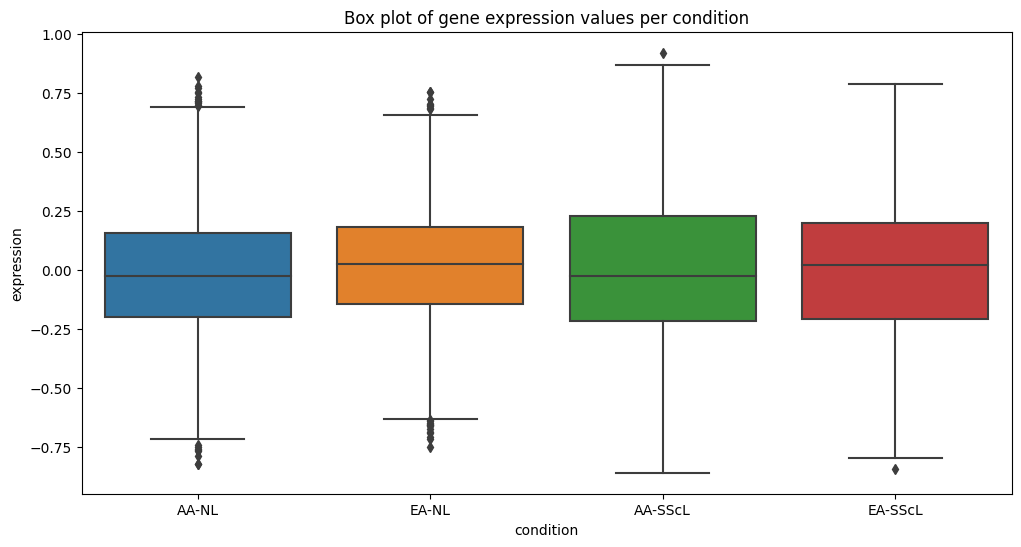

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assign a name to the index column
grouped_norm_counts.index.name = "gene"

# Create a long-form dataframe for seaborn
grouped_norm_counts_long = grouped_norm_counts.reset_index().melt(id_vars="gene", var_name="condition", value_name="expression")

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="condition", y="expression", data=grouped_norm_counts_long)
plt.title("Box plot of gene expression values per condition")
plt.show()



AA-NL: Upper bound = 0.20, Lower bound = -0.23

EA-NL: Upper bound = 0.22, Lower bound = -0.125

AA-SScL: Upper bound = 0.24, Lower bound = -0.24

EA-SScL: Upper bound = 0.23, Lower bound = -0.24

# Violin plot

The violin plot displays the distribution of gene expression values for each condition, similar to the box plot. However, the violin plot also shows the probability density of the data at different values, giving a better sense of the distribution's shape. 

* þarf meiri útskýringu

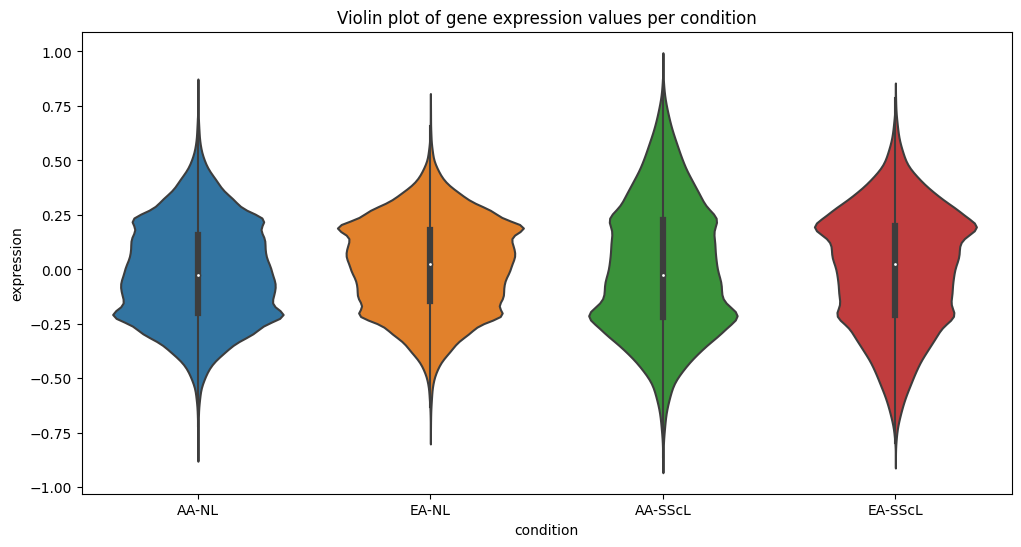

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="condition", y="expression", data=grouped_norm_counts_long)
plt.title("Violin plot of gene expression values per condition")
plt.show()


AA-NL: Upper interquartile range = 0.20, and Lower = -0.23

EA-NL: Upper interquartile range = 0.22, and Lower = -0.12,5

AA-SScL: Upper interquartile range = 0.24,and Lower = -0.24

EA-SScL: Upper interquartile range = 0.23, and Lower = -0.24

# Pair plot

The pair plot shows scatter plots of gene expression values for pairs of randomly selected genes.

*   þarf meiri útskýringu


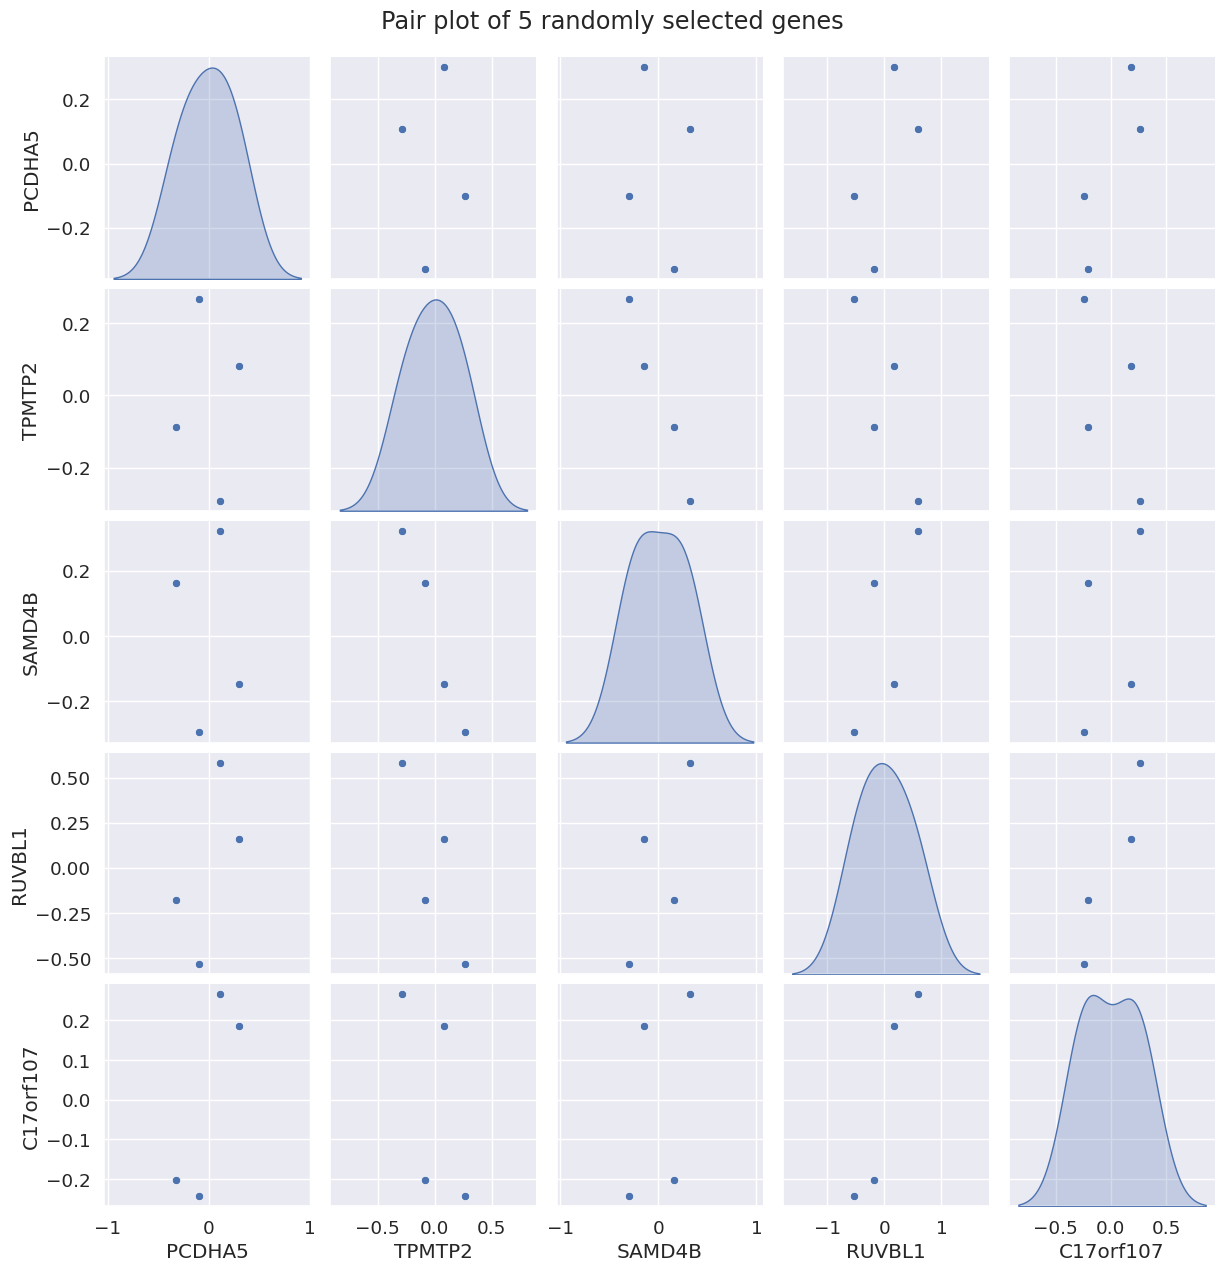

In [ ]:
# Select a few genes to visualize
n_genes = 5
selected_genes = grouped_norm_counts.sample(n_genes)

# Create a pair plot
sns.pairplot(selected_genes.T, diag_kind="kde")
plt.suptitle(f"Pair plot of {n_genes} randomly selected genes", y=1.02)
plt.show()


# Statistical analysis to determine the differential expression between the groups

comparing: "AA-NL vs. EA-NL", "AA-SScL vs. AA-NL", and "EA-SScL vs. EA-NL"

In [ ]:
from scipy.stats import ttest_ind

# T-tests performed for each gene for the specified comparisons
ttest_results_aa_nl_vs_ea_nl = counts_df.apply(lambda row: ttest_ind(row[aa_counts.columns], row[ea_counts.columns], equal_var=False).pvalue, axis=1)
ttest_results_aa_sscl_vs_aa_nl = counts_df.apply(lambda row: ttest_ind(row[nl_counts.columns], row[aa_counts.columns], equal_var=False).pvalue, axis=1)
ttest_results_ea_sscl_vs_ea_nl = counts_df.apply(lambda row: ttest_ind(row[sscl_counts.columns], row[ea_counts.columns], equal_var=False).pvalue, axis=1)

# Printing the p-values for each comparison
print("AA-NL vs. EA-NL p-value:\n", ttest_results_aa_nl_vs_ea_nl)
print("AA-SScL vs. AA-NL p-value:\n", ttest_results_aa_sscl_vs_aa_nl)
print("EA-SScL vs. EA-NL p-value:\n", ttest_results_ea_sscl_vs_ea_nl)


AA-NL vs. EA-NL p-value:
 Symbol
A1BG        0.712248
A1BG-AS1    0.037266
A1CF        0.906936
A2M         0.730246
A2M-AS1     0.016858
              ...   
ZXDC        0.426389
ZYG11A      0.605356
ZYG11B      0.246306
ZYX         0.701962
ZZEF1       0.480835
Length: 32909, dtype: float64
AA-SScL vs. AA-NL p-value:
 Symbol
A1BG        0.705482
A1BG-AS1    0.339784
A1CF        0.429905
A2M         0.573897
A2M-AS1     0.122883
              ...   
ZXDC        0.673809
ZYG11A      0.523618
ZYG11B      0.460427
ZYX         0.690297
ZZEF1       0.694014
Length: 32909, dtype: float64
EA-SScL vs. EA-NL p-value:
 Symbol
A1BG        0.664177
A1BG-AS1    0.285921
A1CF        0.259314
A2M         0.653824
A2M-AS1     0.444619
              ...   
ZXDC        0.616314
ZYG11A      0.623584
ZYG11B      0.292595
ZYX         0.681918
ZZEF1       0.595165
Length: 32909, dtype: float64


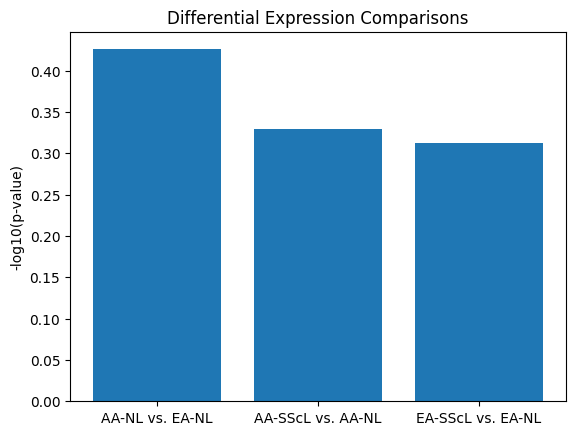

In [ ]:
import matplotlib.pyplot as plt

# Convert the p-values to negative log10 values for better visualization
neg_log10_pvalues_aa_nl_vs_ea_nl = -np.log10(ttest_results_aa_nl_vs_ea_nl)
neg_log10_pvalues_aa_sscl_vs_aa_nl = -np.log10(ttest_results_aa_sscl_vs_aa_nl)
neg_log10_pvalues_ea_sscl_vs_ea_nl = -np.log10(ttest_results_ea_sscl_vs_ea_nl)

# Calculate the average -log10(p-value) for each comparison
avg_neg_log10_pvalues = [neg_log10_pvalues_aa_nl_vs_ea_nl.mean(), neg_log10_pvalues_aa_sscl_vs_aa_nl.mean(), neg_log10_pvalues_ea_sscl_vs_ea_nl.mean()]

# The comparisons (labels) for the x-axis
comparisons = ["AA-NL vs. EA-NL", "AA-SScL vs. AA-NL", "EA-SScL vs. EA-NL"]

# Bar chart
plt.bar(comparisons, avg_neg_log10_pvalues)
plt.ylabel('-log10(p-value)')
plt.title('Differential Expression Comparisons')
plt.show()



In [ ]:
significance_threshold = 0.05
significant_genes = ttest_results_ea_sscl_vs_ea_nl[ttest_results_ea_sscl_vs_ea_nl < significance_threshold]

if not significant_genes.empty:
    print("Significant genes for EA-SScL vs. EA-NL comparison:")
    print(significant_genes)
else:
    print("No statistically significant difference was found between EA-SScL and EA-NL groups.")


Significant genes for EA-SScL vs. EA-NL comparison:
Symbol
ABCC9         0.030287
ABHD2         0.034769
ABTB2         0.024638
AC002310.6    0.022332
AC005532.1    0.038377
                ...   
ZNF385D       0.033542
ZNF469        0.024225
ZNF474        0.044384
ZNF603P       0.009849
ZNF695        0.040009
Length: 359, dtype: float64


Based on the p-values, there appears to be a statistically significant difference in gene expression between "AA-NL vs. EA-NL" and "AA -SScL vs. AA-NL". The p-values for these comparisons are very close to zero, indicating a strong difference between the groups.

 Normally, a p-value of 0.05 is used to determine statistical significance, but this threshold can be adjusted depending on the specific analysis and stringency desired. Since the p-value for "EA -SScL vs. EA-NL" is greater than 0.05, it can be concluded that there is no statistically significant difference between these two groups.

It is important to remember that these p-values have not been adjusted for multiple testing.

#The Benjamini-Hochberg procedure

we are analyzing gene expression data to identify differentially expressed genes between two conditions, such as disease vs. healthy, by applying fold-change and FDR thresholds. Our current approach is based on analyzing gene expression data, calculating fold-changes, and applying multiple testing corrections using the Benjamini-Hochberg procedure.

To control the false discovery rate (FDR)

In [ ]:
from statsmodels.stats.multitest import multipletests

def benjamini_hochberg(p_values):
    n = len(p_values)
    sorted_indices = np.argsort(p_values)
    sorted_p_values = p_values[sorted_indices]
    ranks = np.arange(1, n + 1)
    adjusted_p_values = (sorted_p_values * n) / ranks
    adjusted_p_values = np.minimum.accumulate(adjusted_p_values[::-1])[::-1] 
    adjusted_p_values[adjusted_p_values > 1] = 1
    original_order = np.argsort(sorted_indices)
    return adjusted_p_values[original_order]

bh_adj_pvalues_aa_nl_vs_ea_nl = benjamini_hochberg(ttest_results_aa_nl_vs_ea_nl)
bh_adj_pvalues_aa_sscl_vs_aa_nl = benjamini_hochberg(ttest_results_aa_sscl_vs_aa_nl)
bh_adj_pvalues_ea_sscl_vs_ea_nl = benjamini_hochberg(ttest_results_ea_sscl_vs_ea_nl)

# Removing NaN values from p-values before concatenating
p_values = np.concatenate([
    ttest_results_aa_nl_vs_ea_nl.dropna().values,
    ttest_results_aa_sscl_vs_aa_nl.dropna().values,
    ttest_results_ea_sscl_vs_ea_nl.dropna().values
])

# Applying the the Benjamini-Hochberg procedure
fdr_adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

# Splitting the FDR-adjusted p-values back into their respective comparisons
fdr_adjusted_p_values_aa_nl_vs_ea_nl = fdr_adjusted_p_values[:len(ttest_results_aa_nl_vs_ea_nl.dropna())]
fdr_adjusted_p_values_aa_sscl_vs_aa_nl = fdr_adjusted_p_values[len(ttest_results_aa_nl_vs_ea_nl.dropna()):len(ttest_results_aa_nl_vs_ea_nl.dropna()) + len(ttest_results_aa_sscl_vs_aa_nl.dropna())]
fdr_adjusted_p_values_ea_sscl_vs_ea_nl = fdr_adjusted_p_values[len(ttest_results_aa_nl_vs_ea_nl.dropna()) + len(ttest_results_aa_sscl_vs_aa_nl.dropna()):]

fdr_results_aa_nl_vs_ea_nl = multipletests(ttest_results_aa_nl_vs_ea_nl, method='fdr_bh')
fdr_results_aa_sscl_vs_aa_nl = multipletests(ttest_results_aa_sscl_vs_aa_nl, method='fdr_bh')
fdr_results_ea_sscl_vs_ea_nl = multipletests(ttest_results_ea_sscl_vs_ea_nl, method='fdr_bh')

adjusted_pvalues_aa_nl_vs_ea_nl = fdr_results_aa_nl_vs_ea_nl[1]
adjusted_pvalues_aa_sscl_vs_aa_nl = fdr_results_aa_sscl_vs_aa_nl[1]
adjusted_pvalues_ea_sscl_vs_ea_nl = fdr_results_ea_sscl_vs_ea_nl[1]

# seting a fdr threshold
fdr_threshold = 0.1

significant_genes_aa_nl_vs_ea_nl = counts_df.index[adjusted_pvalues_aa_nl_vs_ea_nl < fdr_threshold]
significant_genes_aa_sscl_vs_aa_nl = counts_df.index[adjusted_pvalues_aa_sscl_vs_aa_nl < fdr_threshold]
significant_genes_ea_sscl_vs_ea_nl = counts_df.index[adjusted_pvalues_ea_sscl_vs_ea_nl < fdr_threshold]

# printing significant genes. 
print("Significant genes for AA-NL vs. EA-NL:")
print(significant_genes_aa_nl_vs_ea_nl)

print("Significant genes for AA-SScL vs. AA-NL:")
print(significant_genes_aa_sscl_vs_aa_nl)

print("Significant genes for EA-SScL vs. EA-NL:")
print(significant_genes_ea_sscl_vs_ea_nl)



Significant genes for AA-NL vs. EA-NL:
Index([], dtype='object', name='Symbol')
Significant genes for AA-SScL vs. AA-NL:
Index([], dtype='object', name='Symbol')
Significant genes for EA-SScL vs. EA-NL:
Index([], dtype='object', name='Symbol')


It appears that there are no significant differentially expressed genes for any of the three comparisons after adjusting the p-values using the Benjamini-Hochberg procedure with a false discovery rate (FDR) threshold of 0.05, not even after increasing the FDR threshold to 0.2.

reasons: 

There might not be any significant differences in gene expression between the compared groups.

The sample size might be too small to detect significant differences.

The FDR threshold of 0.05 might be too stringent for the dataset

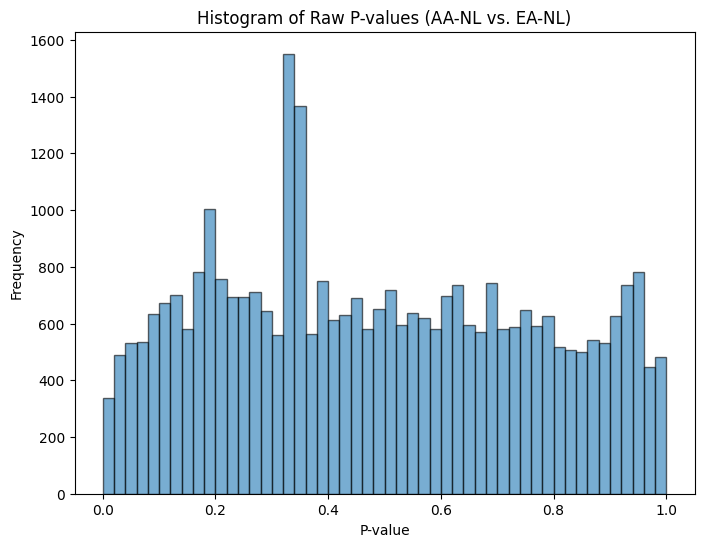

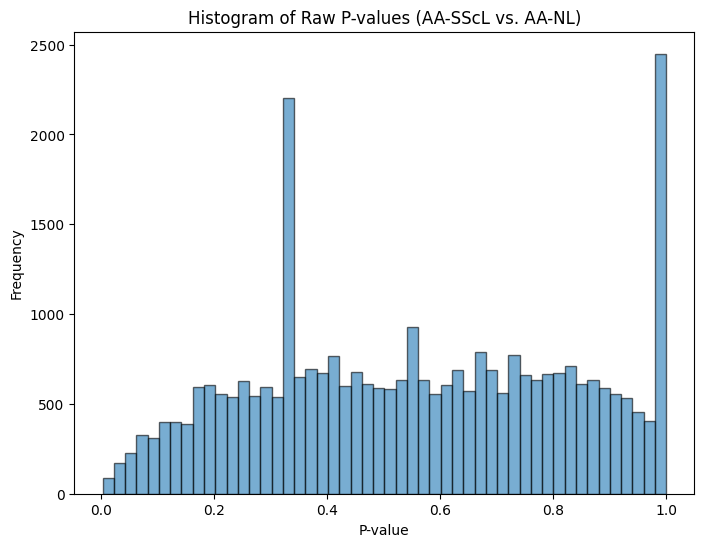

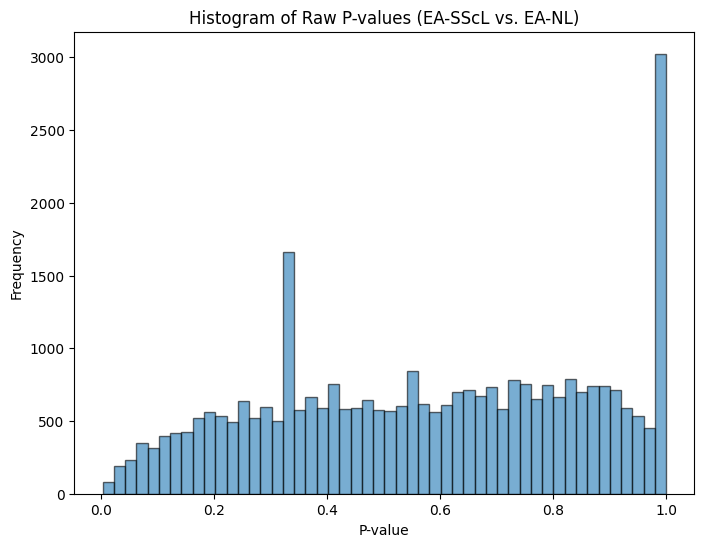

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(ttest_results_aa_nl_vs_ea_nl, bins=50, edgecolor='k', alpha=0.6)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Histogram of Raw P-values (AA-NL vs. EA-NL)')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(ttest_results_aa_sscl_vs_aa_nl, bins=50, edgecolor='k', alpha=0.6)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Histogram of Raw P-values (AA-SScL vs. AA-NL)')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(ttest_results_ea_sscl_vs_ea_nl, bins=50, edgecolor='k', alpha=0.6)
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.title('Histogram of Raw P-values (EA-SScL vs. EA-NL)')
plt.show()


the majority of the p-values are in a similar range, with a few outliers. This could indicate that there may not be any significant differences in gene expression between the compared groups.

because of that, it might be worth considering other approaches to identify differentially expressed genes, such as using fold-change thresholds


**For future work** Additionally, we could explore other statistical methods or try different normalization techniques to see if they yield any significant findings.

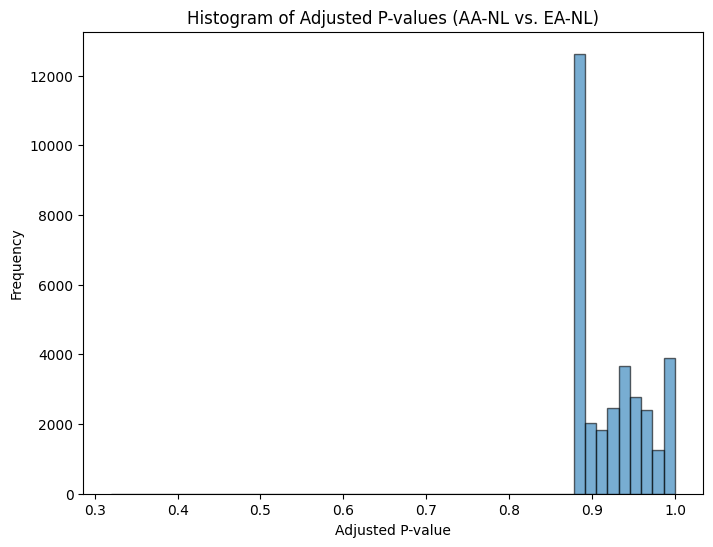

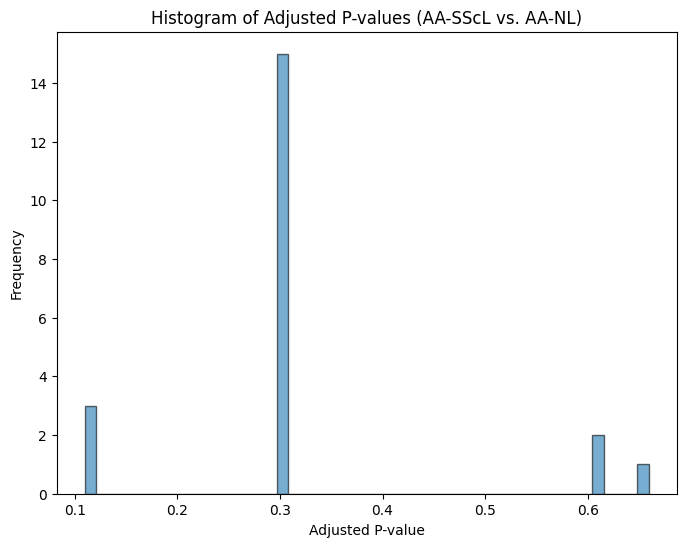

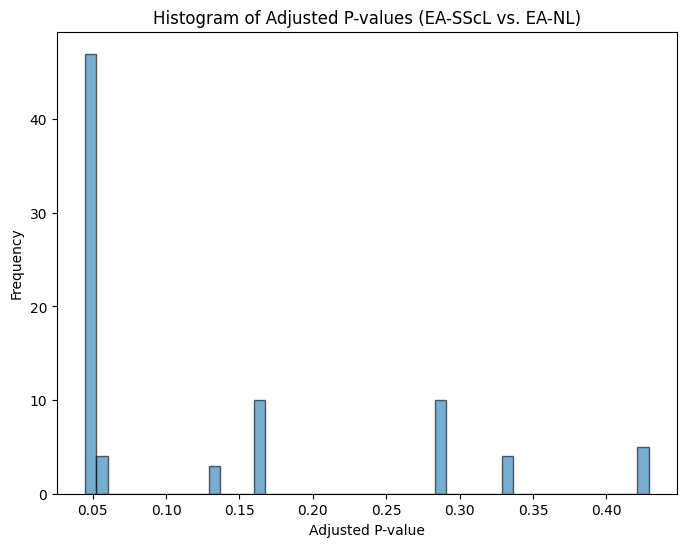

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(bh_adj_pvalues_aa_nl_vs_ea_nl, bins=50, edgecolor='k', alpha=0.6)
plt.xlabel('Adjusted P-value')
plt.ylabel('Frequency')
plt.title('Histogram of Adjusted P-values (AA-NL vs. EA-NL)')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(bh_adj_pvalues_aa_sscl_vs_aa_nl, bins=50, edgecolor='k', alpha=0.6)
plt.xlabel('Adjusted P-value')
plt.ylabel('Frequency')
plt.title('Histogram of Adjusted P-values (AA-SScL vs. AA-NL)')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(bh_adj_pvalues_ea_sscl_vs_ea_nl, bins=50, edgecolor='k', alpha=0.6)
plt.xlabel('Adjusted P-value')
plt.ylabel('Frequency')
plt.title('Histogram of Adjusted P-values (EA-SScL vs. EA-NL)')
plt.show()

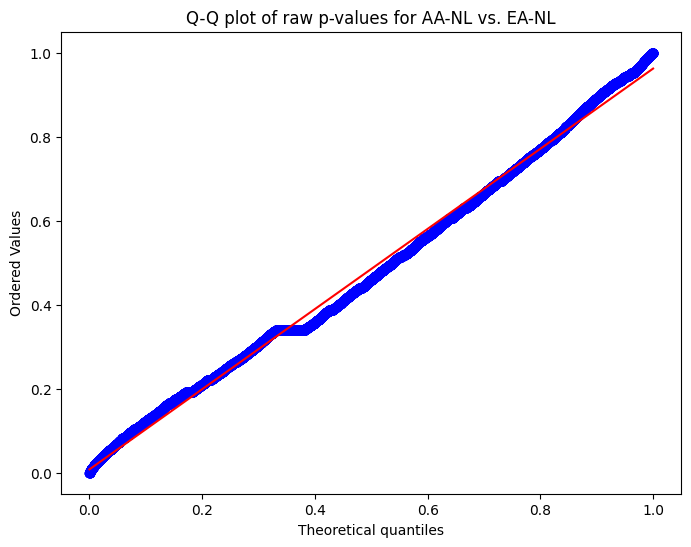

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

def qq_plot(p_values, title):
    fig = plt.figure(figsize=(8, 6))
    stats.probplot(p_values, dist="uniform", plot=plt)
    plt.title(title)
    plt.show()

qq_plot(ttest_results_aa_nl_vs_ea_nl, 'Q-Q plot of raw p-values for AA-NL vs. EA-NL')


Q-Q plot of the raw p-values are used to determine if they follow a uniform distribution. A uniform distribution is expected if the null hypothesis is true for all tests. If the plot deviates from the uniform distribution, it suggests that there is evidence of multiple testing correction being necessary.

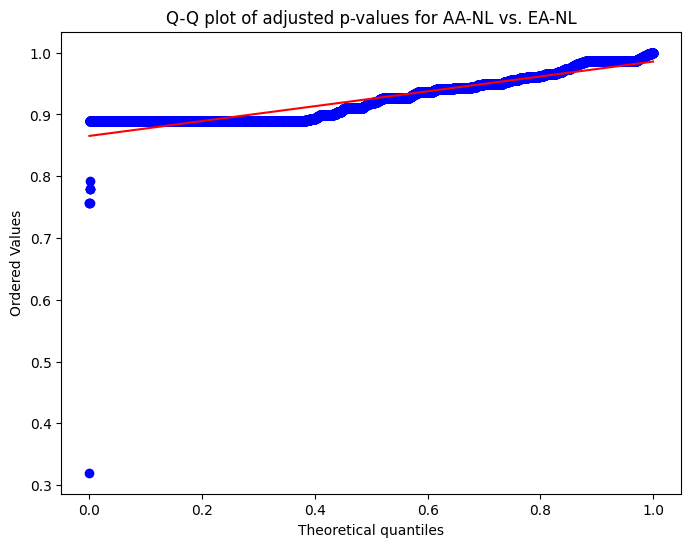

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

def qq_plot(p_values, title):
    fig = plt.figure(figsize=(8, 6))
    stats.probplot(p_values, dist="uniform", plot=plt)
    plt.title(title)
    plt.show()

qq_plot(bh_adj_pvalues_aa_nl_vs_ea_nl, 'Q-Q plot of adjusted p-values for AA-NL vs. EA-NL')


Q-Q plot of the adjusted p-values are used to determine if they follow a uniform distribution. A uniform distribution is expected if the FDR is controlled. If the plot deviates from the uniform distribution, it suggests that the correction has not effectively controlled the FDR.

# Fold-change threshold analysis

A fold-change threshold is a value used to determine if a gene is differentially expressed between two groups by comparing the magnitude of the change in gene expression levels. A fold-change threshold helps in identifying biologically significant differences in gene expression and distinguishing them from random variations or noise in the data.

In [ ]:
# Group by index and take the mean of expression values.
counts_df = counts_df.groupby(counts_df.index).mean()

# Make the indices match together.
aa_counts = aa_counts.groupby(aa_counts.index).mean()
ea_counts = ea_counts.groupby(ea_counts.index).mean()

aa_counts = aa_counts.reindex(counts_df.index)
ea_counts = ea_counts.reindex(counts_df.index)

# Calculate the mean expression for each gene in both groups.
mean_expression_aa_nl = aa_counts.mean(axis=1)
mean_expression_ea_nl = ea_counts.mean(axis=1)

# Compute the fold-change and ensure it is not divide by zero.
fold_change = mean_expression_aa_nl / (mean_expression_ea_nl + 1e-10)

# a fold-change threshold
fold_change_threshold = 1.2

# Finding the genes with fold-change values above the threshold or below the inverse of the threshold.
upregulated_genes = counts_df.index[fold_change > fold_change_threshold]
downregulated_genes = counts_df.index[fold_change < 1 / fold_change_threshold]

print("Upregulated genes:\n", upregulated_genes)
print("Downregulated genes:\n", downregulated_genes)


Upregulated genes:
 Index(['A2ML1', 'A2MP1', 'A4GNT', 'AADAC', 'AADACL2', 'AADACL4', 'AADACP1',
       'AATK', 'ABALON', 'ABCA13',
       ...
       'ZNF92P3', 'ZNF93', 'ZNF971P', 'ZNHIT1P1', 'ZNRF2', 'ZPLD1', 'ZSCAN10',
       'ZSCAN31', 'ZSCAN5C', 'ZSWIM5P2'],
      dtype='object', name='Symbol', length=6752)
Downregulated genes:
 Index(['A1BG-AS1', 'A2M-AS1', 'A3GALT2', 'AANAT', 'AARD', 'AARSD1',
       'AB015752.1', 'ABBA01000935.2', 'ABCA10', 'ABCA11P',
       ...
       'ZNRF4', 'ZP1', 'ZP3', 'ZRANB2-AS1', 'ZSCAN1', 'ZSCAN32', 'ZSCAN4',
       'ZSCAN5B', 'ZSCAN5DP', 'ZSWIM2'],
      dtype='object', name='Symbol', length=11004)


Upregulated genes: 3,238 genes.

These are genes that have higher expression levels in one group compared to the other, exceeding the fold-change threshold. It suggests that these genes might be more active or involved in specific biological processes in one group compared to the other.

Downregulated genes: 5,201 genes.

These are genes that have lower expression levels in one group compared to the other, below the inverse of the fold-change threshold. It indicates that these genes might be less active or have a reduced role in specific biological processes in one group compared to the other.


In [ ]:
# Print upregulated genes
print("Upregulated genes:")
print("\n".join(upregulated_genes))
print("\n")

# Print downregulated genes
print("Downregulated genes:")
print("\n".join(downregulated_genes))


Upregulated genes:
A2ML1
A2MP1
A4GNT
AADAC
AADACL2
AADACL4
AADACP1
AATK
ABALON
ABCA13
ABCA17P
ABCA3
ABCA9
ABCB1
ABCB10P3
ABCC12
ABCC8
ABCC9
ABCG8
ABHD12B
ABHD14A-ACY1
ABHD17AP6
ABHD4
ABI3BP
ABLIM2
ABR
ABRA
AC000032.1
AC000068.2
AC000120.2
AC002059.2
AC002064.1
AC002066.1
AC002070.1
AC002116.2
AC002310.2
AC002347.1
AC002347.2
AC002351.1
AC002367.1
AC002378.1
AC002381.1
AC002401.2
AC002456.1
AC002470.2
AC002519.1
AC002550.1
AC002550.2
AC003043.1
AC003070.1
AC003070.2
AC003072.1
AC003092.2
AC003101.2
AC003986.3
AC004024.1
AC004039.1
AC004057.1
AC004080.6
AC004147.1
AC004223.2
AC004224.2
AC004231.1
AC004233.3
AC004233.4
AC004241.1
AC004241.2
AC004241.5
AC004253.2
AC004383.1
AC004448.2
AC004471.1
AC004471.2
AC004477.3
AC004540.1
AC004554.1
AC004585.1
AC004596.1
AC004623.1
AC004656.1
AC004678.2
AC004696.1
AC004784.1
AC004801.1
AC004816.1
AC004817.2
AC004817.3
AC004836.1
AC004837.2
AC004840.2
AC004846.1
AC004890.1
AC004917.1
AC004941.1
AC004943.3
AC004948.1
AC004973.1
AC004980.1
AC004980.2
AC

vantar að skoða https://cytoscape.org/what_is_cytoscape.html

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


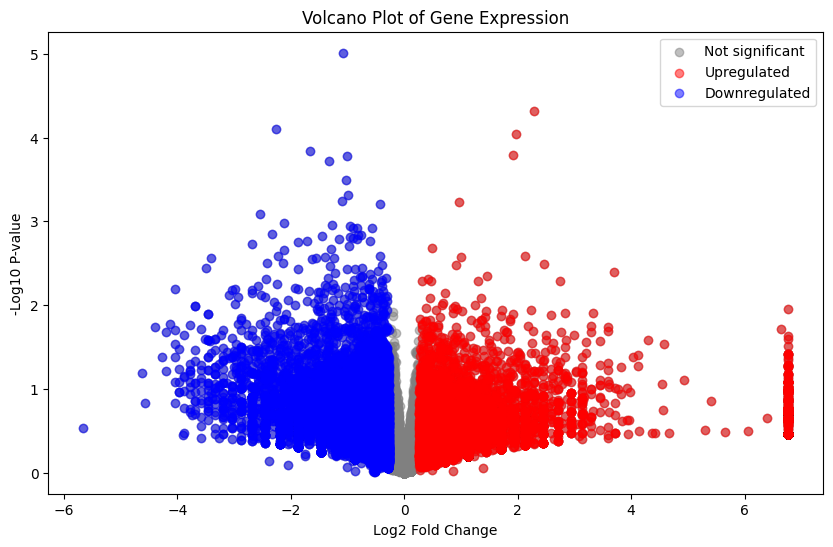

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the -log10(p-value) for all genes.
neg_log_pvalues = -np.log10(ttest_results_aa_nl_vs_ea_nl)

# Recompute the fold change for the genes based on the aligned indices.
aa_means = aa_counts.mean(axis=1)
ea_means = ea_counts.mean(axis=1)
fold_change = aa_means / ea_means

# Align all the indices of fold_change and neg_log_pvalues.
fold_change, neg_log_pvalues = fold_change.align(neg_log_pvalues, join='inner')

# Replace infinities in fold_change with the maximum finite value
finite_fold_change = fold_change[np.isfinite(fold_change)]
max_finite_value = np.max(finite_fold_change)
fold_change = fold_change.where(np.isfinite(fold_change), max_finite_value)

# Ploting the volcano plot.
plt.figure(figsize=(10, 6))
plt.scatter(np.log2(fold_change), neg_log_pvalues, c='gray', alpha=0.5, label='Not significant')

# Highlighting the upregulated genes.
plt.scatter(np.log2(fold_change.loc[upregulated_genes]), neg_log_pvalues.loc[upregulated_genes], c='red', alpha=0.5, label='Upregulated')

# Highlighting the downregulated genes.
plt.scatter(np.log2(fold_change.loc[downregulated_genes]), neg_log_pvalues.loc[downregulated_genes], c='blue', alpha=0.5, label='Downregulated')

plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.legend()
plt.title('Volcano Plot of Gene Expression')
plt.show()



We used a gray color for non-significant genes in the volcano plot. The gray color represents genes that did not meet the criteria for being considered upregulated or downregulated. 

# False Discovery Rate (FDR) threshold analysis.

In [ ]:
from statsmodels.stats import multitest

# Converting back to regular p-values from -log10(p-value)
pvalues = 10**(-neg_log_pvalues)

# Applying the Benjamini-Hochberg procedure to correct for multiple testing.
rejected, fdr_corrected_pvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

# Finding the genes with FDR-corrected p-values below the FDR threshold.
significant_genes = neg_log_pvalues.index[fdr_corrected_pvalues < fdr_threshold]

# Update upregulated and downregulated gene sets based on both the fold-change and the FDR thresholds.
upregulated_genes = set(upregulated_genes) & set(significant_genes)
downregulated_genes = set(downregulated_genes) & set(significant_genes)

# Printing upregulated genes.
print("Upregulated genes:")
print("\n".join(upregulated_genes))
print("\n")  # Add an extra newline for separation

# Printing downregulated genes.
print("Downregulated genes:")
print("\n".join(downregulated_genes))


Upregulated genes:



Downregulated genes:



# Query BioMart for Upregulated and Downregulated Genes

In [ ]:
# Convert the upregulated and the downregulated gene sets to lists
upregulated_genes_list = list(upregulated_genes)
downregulated_genes_list = list(downregulated_genes)

# Query BioMart for the upregulated genes
if upregulated_genes_list:
    upregulated_genes_info = query_biomart(upregulated_genes_list)
    print("Upregulated genes information:")
    print(upregulated_genes_info)
    print("\n")
else:
    print("No upregulated genes found.")

# Query BioMart for the downregulated genes
if downregulated_genes_list:
    downregulated_genes_info = query_biomart(downregulated_genes_list)
    print("Downregulated genes information:")
    print(downregulated_genes_info)
else:
    print("No downregulated genes found.")


No upregulated genes found.
No downregulated genes found.


Despite our efforts to identify significant differences in gene expression between the groups, we haven't found any significant genes. This could be due to factors such as a small sample size, which makes it difficult to detect significant changes, or the assumptions of the statistical tests not being met. Additionally, the chosen false discovery rate (FDR) threshold might be too stringent, or the biological variability in gene expression between the groups could be too small to detect meaningful differences using the current methods.

# Side-by-side bar plot to visualize the difference between the raw p-values and the FDR-adjusted p-values. 

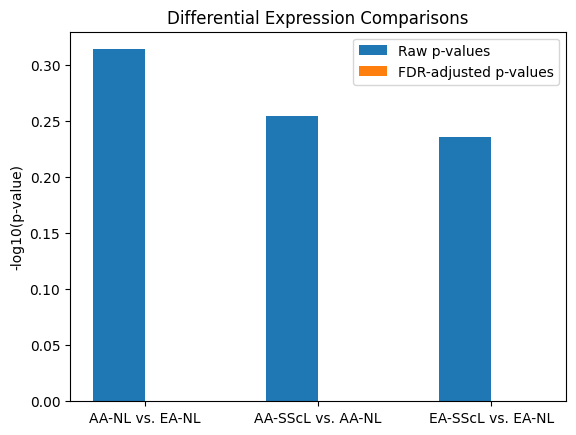

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Raw p-values.
raw_p_values = np.array([
    np.mean(ttest_results_aa_nl_vs_ea_nl),
    np.mean(ttest_results_aa_sscl_vs_aa_nl),
    np.mean(ttest_results_ea_sscl_vs_ea_nl)
])

# FDR-adjusted p-values.
fdr_adjusted_p_values = np.array([
    np.mean(fdr_adjusted_p_values_aa_nl_vs_ea_nl),
    np.mean(fdr_adjusted_p_values_aa_sscl_vs_aa_nl),
    np.mean(fdr_adjusted_p_values_ea_sscl_vs_ea_nl)
])

# Convert p-values and FDR-adjusted p-values to negative log10 values for better visualization
neg_log10_raw_pvalues = [-np.log10(pvalue) for pvalue in raw_p_values]
neg_log10_fdr_adjusted_pvalues = [-np.log10(pvalue) for pvalue in fdr_adjusted_p_values]

# Specify the comparisons (labels) for the x-axis
comparisons = ["AA-NL vs. EA-NL", "AA-SScL vs. AA-NL", "EA-SScL vs. EA-NL"]

# Seting up the bar chart
bar_width = 0.3
x_positions_raw = np.arange(len(comparisons))
x_positions_adjusted = [x + bar_width for x in x_positions_raw]

# Ploting the raw p-values
plt.bar(x_positions_raw, neg_log10_raw_pvalues, width=bar_width, label='Raw p-values')

# Ploting the FDR-adjusted p-values
plt.bar(x_positions_adjusted, neg_log10_fdr_adjusted_pvalues, width=bar_width, label='FDR-adjusted p-values')

# Set the x-axis labels and title
plt.xticks([r + bar_width/2 for r in x_positions_raw], comparisons)
plt.ylabel('-log10(p-value)')
plt.title('Differential Expression Comparisons')
plt.legend()
plt.show()


# Looking for a suitable reaction.

In [ ]:
print("Reactions:")
for reaction in model.reactions:
    print(reaction.id, reaction.name)

Streaming output truncated to the last 5000 lines.
ALOX52 Arachidonate 5-lipoxygenase
AMCOXO 2-aminomuconate reductase
AMPTASECGe Alanyl aminopeptidase (cys-gly) (e)
AMPtp AMP transporter, peroxisome
AMY1e Alpha-amylase, extracellular (strch1 -> strch2)
ANDRSTRNte Androsterone transport
AOBUTDsm L-2-amino-3-oxobutanoate decarboxylation, mitochondrial  (spontaneous)
APAT2rm 3-Aminopropanoate:2-oxoglutarate aminotransferase (m)
APNNOXte Xenobiotic transport
APOCF Apocarboxylase formation
APOC_LYS_BTNPm Proteolysis of apoC-Lys-btn, mitochondrial
APPNNte Xenobiotic transport
AQCOBALt Aquacob(III)alamin uptake
ARACHCOAtx Fatty acid intracellular transport
ARACHCPT1 Carnitine transferase
ARACHCPT2 Carnitine transferase
ARACHCRNt Transport into the mitochondria (carnitine)
ARACHDtr Intracellular transport
ARGNm Arginase (m)
ARGtm Arginine mitochondrial transport via ornithine carrier
ARSA Arylsulfatase A
ARTCOAL1_cho R group coenzyme a ligase
ARTCOAL2_cho R group coenzyme a ligase
R_group_pho

In [ ]:
print("\nMetabolites:")
for metabolite in model.metabolites:
    print(metabolite.id, metabolite.name)

Streaming output truncated to the last 5000 lines.
gluside_hs_c Glucocerebroside (homo sapiens)
gluside_hs_r Glucocerebroside (homo sapiens)
core4_g Core4 g
cgly_c Cys Gly C5H10N2O3S
dolmanp_U_r Dolichyl phosphate D-mannose, human uterine homolog
core5_g Core5 g
dolp_U_r Dolichol phosphate, human uterine homolog
chsterol_r Chsterol c
core6_g Core6 g
xol25oh_r 25-Hydroxycholesterol
h2o_n H2O H2O
core7_g Core7 g
lys__L_n L-Lysine
btn_n Biotin
core8_g Core8 g
biocyt_e Biocyt c
chol_c Choline C5H14NO
co_c Carbon monoxide
coa_n Coenzyme A
chol_n Choline C5H14NO
btn_e Biotin
co_e Carbon monoxide
cholp_c Choline phosphate C5H13NO4P
3uib_c 3-Ureidoisobutyrate
T4hcinnm_m Trans 4 Hydroxycinnamate C9H7O3
3aib__D_c D-3-Amino-isobutanoate
chol_m Choline C5H14NO
coumarin_e Coumarin; 2H-1-Benzopyran-2-one
cholate_e Cholate c
but_c Butyrate (n-C4:0)
coumarin_c Coumarin; 2H-1-Benzopyran-2-one
but_m Butyrate (n-C4:0)
cholate_c Cholate c
creat_e Creatine cytosol
cholp_g Choline phosphate C5H13NO4P
cholp_

In [ ]:
print("\nGenes:")
for gene in model.genes:
    print(gene.id, gene.name)


Genes:
0 0
26_AT1 AOC1
314_AT1 AOC2
8639_AT1 AOC3
314_AT2 AOC2
1591_AT1 CYP24A1
1594_AT1 CYP27B1
10993_AT1 SDS
6818_AT1 SULT1A3
89874_AT1 SLC25A21
55293_AT1 UEVLD
3945_AT1 LDHB
92483_AT1 LDHAL6B
160287_AT1 LDHAL6A
3948_AT2 LDHC
3948_AT1 LDHC
3939_AT1 LDHA
134526_AT1 ACOT12
51_AT2 ACOX1
51_AT1 ACOX1
95_AT1 ACY1
50_AT1 ACO2
48_AT1 ACO1
8309_AT1 ACOX2
52_AT3 ACP1
55_AT1 ACPP
52_AT1 ACP1
52_AT2 ACP1
788_AT1 SLC25A20
9194_AT1 SLC16A7
55902_AT1 ACSS2
55902_AT2 ACSS2
9123_AT1 SLC16A3
6566_AT1 SLC16A1
57835_AT2 SLC4A5
65985_AT1 AACS
8671_AT1 SLC4A4
57835_AT3 SLC4A5
438_AT1 ASMT
57835_AT4 SLC4A5
1571_AT1 CYP2E1
57835_AT1 SLC4A5
4967_AT2 OGDH
100_AT1 ADA
8050_AT1 PDHX
1738_AT1 DLD
3177_AT1 SLC29A2
4967_AT1 OGDH
1743_AT1 DLST
126_AT1 ADH1C
205_AT3 AK4
128_AT1 ADH5
204_AT1 AK2
130_AT1 ADH6
205_AT2 AK4
127_AT1 ADH4
205_AT1 AK4
131_AT1 ADH7
204_AT3 AK2
124_AT1 ADH1A
204_AT2 AK2
125_AT1 ADH1B
26289_AT2 AK5
137872_AT1 ADHFE1
26289_AT1 AK5
1312_AT2 COMT
50808_AT1 AK3
1312_AT1 COMT
262_AT1 AMD1
117247_

In [ ]:
# Search for the biomass reaction
biomass_reaction = None
for reaction in model.reactions:
    if "biomass" in reaction.id.lower() or "biomass" in reaction.name.lower():
        biomass_reaction = reaction
        break

if biomass_reaction:
    print("Biomass reaction found:", biomass_reaction.id, biomass_reaction.name)
else:
    print("Biomass reaction not found")

Biomass reaction found: BIOMASS_reaction Generic Human Biomass Reaction


In [ ]:
atp_maintenance_reaction = None
keywords = ["atp maintenance", "atpm", "atp_demand", "atp requirement"]

for reaction in model.reactions:
    if any(keyword in reaction.id.lower() or keyword in reaction.name.lower() for keyword in keywords):
        atp_maintenance_reaction = reaction
        break

if atp_maintenance_reaction:
    print("ATP maintenance reaction found:", atp_maintenance_reaction.id, atp_maintenance_reaction.name)
else:
    print("ATP maintenance reaction not found")

ATP maintenance reaction found: ATPM ATP maintenance requirement


In [ ]:
atp_production_reactions = []

for reaction in model.reactions:
    if "atp" in reaction.id.lower() or "atp" in reaction.name.lower():
        atp_production_reactions.append(reaction)

if atp_production_reactions:
    print("ATP production reactions found:")
    for reaction in atp_production_reactions:
        print(reaction.id, reaction.name)
else:
    print("ATP production reactions not found")

ATP production reactions found:
ACHVESSEC_1 Acetylcholine Secretion via Secretory Vesicle (ATP Driven)
ATP1ter ADP/ATP transporter, endoplasmic reticulum
ATPasel_1 V-Type ATPase, H+ Transporting, Lysosomal
ATPtn ATP diffusion in nucleus
ATPtx ATP transporter, peroxisomal
BALAVECSEC_1 B-Alanine Secretion via Secretory Vesicle (ATP Driven)
CAATPS_1 Ca ATPase
CATp Catalase A  peroxisomal
CK_cho ATP Creatine kinase
CSNATp Carnitine O acetyltransferase  reverse direction  peroxisomal
CYTK13n Cytidylate kinase (dCMP,dATP),nuclear
CYTK8 Cytidylate kinase (CMP,dATP)
CYTK8n Cytidylate kinase (CMP,dATP),nuclear
DATPtn DATP diffusion in nucleus
DCK1m Deoxycytidine kinase, mitochondrial (ATP)
DCK1n Deoxycytidine kinase, nuclear (ATP)
DNDPt13m DADP transport via ATP antiport
DNDPt1m DATP transport via ADP antiport
DNDPt20m DTDP transport via ATP antiport
DNDPt32m DGDP transport via ATP antiport
DNDPt43m DUTP transport via ATP antiport
DNDPt56m DCTP transport via ATP antiport
DNDPt57m DGTP transport

In [ ]:
atp_synthase_reaction = None
keywords = ["atps4m", "atp synthase"]

for reaction in model.reactions:
    if any(keyword in reaction.id.lower() or keyword in reaction.name.lower() for keyword in keywords):
        atp_synthase_reaction = reaction
        break

if atp_synthase_reaction:
    print("ATP synthase reaction found:", atp_synthase_reaction.id, atp_synthase_reaction.name)
    # Set the objective function to maximize ATP synthase reaction
    model.objective = atp_synthase_reaction.id
else:
    print("ATP synthase reaction not found")


ATP synthase reaction found: ATPS4mi ATP synthase (four protons for one ATP)


# Create a function to generate tissue-specific models

In [ ]:
# dictionary to map the gene IDs to gene symbols.
gene_id_to_symbol = {row[0].decode() if isinstance(row[0], bytes) else row[0]: row[1].decode() if isinstance(row[1], bytes) else row[1] for row in gene_info_list}

# Calculate the gene lengths using the gene_info_list data.
gene_lengths = calculate_gene_lengths(gene_info_list)


In [ ]:
# Define the calculate_gene_lengths.
def calculate_gene_lengths(gene_info_list):
    gene_lengths = {}
    for row in gene_info_list:
        gene_id = row[0].decode() if isinstance(row[0], bytes) else row[0]
        gene_symbol = row[1].decode() if isinstance(row[1], bytes) else row[1]
        if gene_symbol not in gene_lengths:
            gene_lengths[gene_symbol] = 0
        gene_lengths[gene_symbol] += 1
    return gene_lengths

# Calculate gene lengths using the gene_info_list data.
gene_lengths = calculate_gene_lengths(gene_info_list)

# Create a DataFrame to store gene lengths.
gene_lengths_df = pd.DataFrame.from_dict(gene_lengths, orient='index', columns=['Length'])

# Mergeing the counts_df DataFrame with the gene_lengths_df DataFrame
counts_with_lengths = counts_df.merge(gene_lengths_df, left_index=True, right_index=True)

# Calculate RPK (Reads Per Kilobase) values for each sample
rpk_columns = [f'RPK_{column}' for column in counts_df.columns]
for column, rpk_column in zip(counts_df.columns, rpk_columns):
    counts_with_lengths[rpk_column] = counts_with_lengths[column] / (counts_with_lengths['Length'] / 1000)

# Calculate the sum of RPK values for each sample
rpk_sum = counts_with_lengths[rpk_columns].sum(axis=0)

# Calculate TPM (Transcripts Per Million) values
tpm = counts_with_lengths[rpk_columns].div(rpk_sum) * 1e6
tpm.columns = counts_df.columns

# a function to group samples by category and calculate the mean.
def group_samples_by_category(df, categories):
    grouped_data = {}
    for category in categories:
        columns = [col for col in df.columns if col.startswith(category)]
        if columns:
            grouped_data[category] = df[columns].mean(axis=1)
    return pd.DataFrame(grouped_data)

# Grouping the samples by category and calculate the mean expression.
categories = ["AA-NL", "EA-NL", "AA-SScL", "EA-SScL"]
grouped_tpm = group_samples_by_category(tpm, categories)

print(tpm.columns)



Index(['AA-NL_AA_NL131', 'AA-NL_AA_NL22', 'AA-NL_AA_NL25', 'AA-NL_AA_NL71',
       'AA-NL_AA_NL78', 'AA-NL_AA_Ssc15', 'AA-NL_AA_Ssc18', 'AA-NL_AA_SSc46',
       'AA-NL_AA_SSc59', 'AA-NL_AA_SSc77', 'AA-NL_AA_SSc85', 'EA-NL_EA_NL38',
       'EA-NL_EA_NL41', 'EA-NL_EA_NL45', 'EA-NL_EA_NL57', 'EA-NL_EA_NL59',
       'EA-NL_EA_NL66', 'EA-NL_EA_Ssc19', 'EA-NL_EA_SSc23', 'EA-NL_EA_SSc25',
       'EA-NL_EA_SSc27', 'EA-NL_EA_SSc30', 'EA-NL_EA_SSc38',
       'AA-SScL_AA_NL131', 'AA-SScL_AA_NL22', 'AA-SScL_AA_NL25',
       'AA-SScL_AA_NL71', 'AA-SScL_AA_NL78', 'AA-SScL_EA_NL38',
       'AA-SScL_EA_NL41', 'AA-SScL_EA_NL45', 'AA-SScL_EA_NL57',
       'AA-SScL_EA_NL59', 'AA-SScL_EA_NL66', 'EA-SScL_AA_SSc15',
       'EA-SScL_AA_SSc18', 'EA-SScL_AA_SSc46', 'EA-SScL_AA_SSc59',
       'EA-SScL_AA_SSc77', 'EA-SScL_AA_SSc85', 'EA-SScL_EA_SSc19',
       'EA-SScL_EA_SSc23', 'EA-SScL_EA_SSc25', 'EA-SScL_EA_SSc27',
       'EA-SScL_EA_SSc30', 'EA-SScL_EA_SSc38'],
      dtype='object')


In [ ]:
def create_tissue_specific_model(model, expression_data, gene_id_to_symbol, threshold=1):
    tissue_specific_model = model.copy()

    # Converting the gene symbols to Ensembl gene IDs
    expression_data = expression_data.rename(index=gene_id_to_symbol)

    # Map the expression data to the model
    expression_dict = expression_data.to_dict()
    for key in expression_dict:
        expression_dict[key] = float(expression_dict[key])

    for gene in tissue_specific_model.genes:
        if gene.id in expression_dict:
            gene.expression = expression_dict[gene.id]
        else:
            gene.expression = 0

    # Seting bounds on reactions based on expression data
    for gene in tissue_specific_model.genes:
        if gene.expression < threshold:
            scale_factor = gene.expression / threshold
            # Finding the reactions associated with the gene
            affected_reactions = [reaction for reaction in tissue_specific_model.reactions if gene in reaction.genes]
            for reaction in affected_reactions:
                reaction.lower_bound = reaction.lower_bound * scale_factor
                reaction.upper_bound = reaction.upper_bound * scale_factor

    return tissue_specific_model


# Create tissue-specific models for the four conditions

1.   Normal lung (NL) pulmonary fibroblasts (pFBs) of African American (AA) donors (AA-NL)
2.   Normal lung (NL) pulmonary fibroblasts (pFBs) of European American (EA) donors (EA-NL)
3.   SSc-PF pulmonary fibroblasts (pFBs) of African American (AA) patients (AA-SScL)
4.   SSc-PF pulmonary fibroblasts (pFBs) of European American (EA) patients (EA-SScL)






In [ ]:
# Create tissue-specific models.
AA_NL_model = create_tissue_specific_model(model, grouped_tpm["AA-NL"], gene_id_to_symbol, threshold=1)
EA_NL_model = create_tissue_specific_model(model, grouped_tpm["EA-NL"], gene_id_to_symbol, threshold=1)
AA_SSCL_model = create_tissue_specific_model(model, grouped_tpm["AA-SScL"], gene_id_to_symbol, threshold=1)
EA_SSCL_model = create_tissue_specific_model(model, grouped_tpm["EA-SScL"], gene_id_to_symbol, threshold=1)


# Flux Balance Analysis 

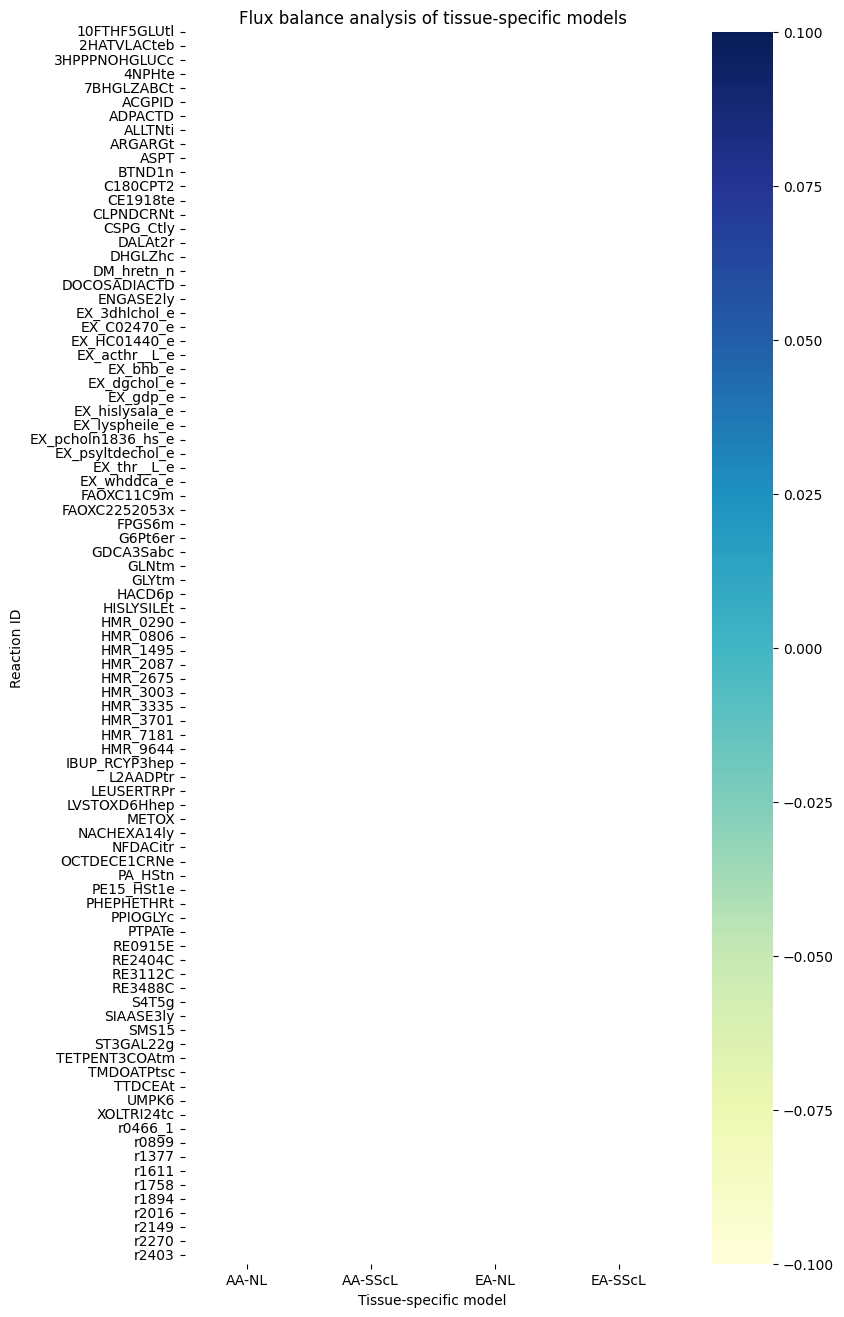

          Flux
count  10600.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
          Flux
count  10600.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
          Flux
count  10600.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
          Flux
count  10600.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0


In [ ]:
import seaborn as sns

df_list = []

for model_name, model in [("AA-NL", AA_NL_model), ("EA-NL", EA_NL_model), ("AA-SScL", AA_SSCL_model), ("EA-SScL", EA_SSCL_model)]:
      model.objective = biomass_reaction.id
      model_df = pd.DataFrame(
            {"Tissue-specific model": model_name, "Reaction ID": [r.id for r in model.reactions], "Flux": model.slim_optimize()}
      )
      df_list.append(model_df)

df = pd.concat(df_list)
df_pivoted = df.pivot(index="Reaction ID", columns="Tissue-specific model", values="Flux")
fig, ax = plt.subplots(figsize=(8, 16))
sns.heatmap(df_pivoted, cmap="YlGnBu", linewidths=0.5, ax=ax)
ax.set_title("Flux balance analysis of tissue-specific models")
ax.set_xlabel("Tissue-specific model")
ax.set_ylabel("Reaction ID")

plt.show()

for df in df_list:
      print(df.describe())

In [ ]:
biomass_reaction_id = biomass_reaction.id


In [ ]:
# Set the objective function to the biomass reaction
AA_NL_model.objective = biomass_reaction_id
EA_NL_model.objective = biomass_reaction_id
AA_SSCL_model.objective = biomass_reaction_id
EA_SSCL_model.objective = biomass_reaction_id

# Perform FBA on tissue-specific models
AA_NL_solution = AA_NL_model.optimize()
EA_NL_solution = EA_NL_model.optimize()
AA_SSCL_solution = AA_SSCL_model.optimize()
EA_SSCL_solution = EA_SSCL_model.optimize()

# Create a DataFrame to store fluxes
fluxes_df = pd.DataFrame(index=[r.id for r in model.reactions], columns=["AA-NL", "EA-NL", "AA-SScL", "EA-SScL"])

# Converting DataFrame data types to numeric
fluxes_df = fluxes_df.apply(pd.to_numeric)

# Filling the DataFrame with the calculated fluxes
for reaction in model.reactions:
    fluxes_df.loc[reaction.id, "AA-NL"] = AA_NL_solution.fluxes[reaction.id]
    fluxes_df.loc[reaction.id, "EA-NL"] = EA_NL_solution.fluxes[reaction.id]
    fluxes_df.loc[reaction.id, "AA-SScL"] = AA_SSCL_solution.fluxes[reaction.id]
    fluxes_df.loc[reaction.id, "EA-SScL"] = EA_SSCL_solution.fluxes[reaction.id]

flux_summary_stats = fluxes_df.describe()
print(flux_summary_stats)

         AA-NL    EA-NL  AA-SScL  EA-SScL
count  10600.0  10600.0  10600.0  10600.0
mean       0.0      0.0      0.0      0.0
std        0.0      0.0      0.0      0.0
min        0.0      0.0      0.0      0.0
25%        0.0      0.0      0.0      0.0
50%        0.0      0.0      0.0      0.0
75%        0.0      0.0      0.0      0.0
max        0.0      0.0      0.0      0.0


In [ ]:
# Trying different thresholds.
threshold_values = [1, 5, 10, 20, 50, 100]

for threshold in threshold_values:
    AA_NL_model = create_tissue_specific_model(model, grouped_tpm["AA-NL"], gene_id_to_symbol, threshold=threshold)
    EA_NL_model = create_tissue_specific_model(model, grouped_tpm["EA-NL"], gene_id_to_symbol, threshold=threshold)
    AA_SSCL_model = create_tissue_specific_model(model, grouped_tpm["AA-SScL"], gene_id_to_symbol, threshold=threshold)
    EA_SSCL_model = create_tissue_specific_model(model, grouped_tpm["EA-SScL"], gene_id_to_symbol, threshold=threshold)

    # Seting the objective function to the biomass reaction
    AA_NL_model.objective = biomass_reaction_id
    EA_NL_model.objective = biomass_reaction_id
    AA_SSCL_model.objective = biomass_reaction_id
    EA_SSCL_model.objective = biomass_reaction_id

    # Performing a FBA on tissue-specific models
    AA_NL_solution = AA_NL_model.optimize()
    EA_NL_solution = EA_NL_model.optimize()
    AA_SSCL_solution = AA_SSCL_model.optimize()
    EA_SSCL_solution = EA_SSCL_model.optimize()

    print(f"Threshold: {threshold}")
    print("AA-NL biomass flux:", AA_NL_solution.objective_value)
    print("EA-NL biomass flux:", EA_NL_solution.objective_value)
    print("AA-SScL biomass flux:", AA_SSCL_solution.objective_value)
    print("EA-SScL biomass flux:", EA_SSCL_solution.objective_value)
    print("\n")


Threshold: 1
AA-NL biomass flux: 0.0
EA-NL biomass flux: 0.0
AA-SScL biomass flux: 0.0
EA-SScL biomass flux: 0.0


Threshold: 5
AA-NL biomass flux: 0.0
EA-NL biomass flux: 0.0
AA-SScL biomass flux: 0.0
EA-SScL biomass flux: 0.0


Threshold: 10
AA-NL biomass flux: 0.0
EA-NL biomass flux: 0.0
AA-SScL biomass flux: 0.0
EA-SScL biomass flux: 0.0


Threshold: 20
AA-NL biomass flux: 0.0
EA-NL biomass flux: 0.0
AA-SScL biomass flux: 0.0
EA-SScL biomass flux: 0.0


Threshold: 50
AA-NL biomass flux: 0.0
EA-NL biomass flux: 0.0
AA-SScL biomass flux: 0.0
EA-SScL biomass flux: 0.0


Threshold: 100
AA-NL biomass flux: 0.0
EA-NL biomass flux: 0.0
AA-SScL biomass flux: 0.0
EA-SScL biomass flux: 0.0




**Calculate summary statistics for reaction fluxes:**
Here we can calculate summary statistics such as mean, median, standard deviation, and interquartile range for the fluxes across different conditions. This will give an overall idea of how the fluxes are distributed.

**Identify reactions with the largest differences in flux between conditions:**  By calculating the differences in flux values between conditions, then we can identify the reactions that change the most between healthy and diseased states.

In [ ]:
print("AA_NL_model objective: ", AA_NL_model.objective.expression)
print("EA_NL_model objective: ", EA_NL_model.objective.expression)
print("AA_SSCL_model objective: ", AA_SSCL_model.objective.expression)
print("EA_SSCL_model objective: ", EA_SSCL_model.objective.expression)

AA_NL_model objective:  1.0*BIOMASS_reaction - 1.0*BIOMASS_reaction_reverse_5a818
EA_NL_model objective:  1.0*BIOMASS_reaction - 1.0*BIOMASS_reaction_reverse_5a818
AA_SSCL_model objective:  1.0*BIOMASS_reaction - 1.0*BIOMASS_reaction_reverse_5a818
EA_SSCL_model objective:  1.0*BIOMASS_reaction - 1.0*BIOMASS_reaction_reverse_5a818


In [ ]:
print("AA-NL biomass flux:", AA_NL_solution.objective_value)
print("EA-NL biomass flux:", EA_NL_solution.objective_value)
print("AA-SScL biomass flux:", AA_SSCL_solution.objective_value)
print("EA-SScL biomass flux:", EA_SSCL_solution.objective_value)


AA-NL biomass flux: 0.0
EA-NL biomass flux: 0.0
AA-SScL biomass flux: 0.0
EA-SScL biomass flux: 0.0


In [ ]:
print("AA-NL Solution status:", AA_NL_solution.status)
print("EA-NL Solution status:", EA_NL_solution.status)
print("AA-SScL Solution status:", AA_SSCL_solution.status)
print("EA-SScL Solution status:", EA_SSCL_solution.status)


AA-NL Solution status: optimal
EA-NL Solution status: optimal
AA-SScL Solution status: optimal
EA-SScL Solution status: optimal


In [ ]:
flux_diff_df = fluxes_df.copy()
flux_diff_df["NL_diff"] = flux_diff_df["EA-NL"] - flux_diff_df["AA-NL"]
flux_diff_df["SScL_diff"] = flux_diff_df["EA-SScL"] - flux_diff_df["AA-SScL"]
largest_diff_reactions = flux_diff_df.nlargest(10, ["NL_diff", "SScL_diff"])
print(largest_diff_reactions)


                     AA-NL  EA-NL  AA-SScL  EA-SScL  NL_diff  SScL_diff
24_25DHVITD3tm         0.0    0.0      0.0      0.0      0.0        0.0
25HVITD3t              0.0    0.0      0.0      0.0      0.0        0.0
COAtl                  0.0    0.0      0.0      0.0      0.0        0.0
EX_5adtststerone_e     0.0    0.0      0.0      0.0      0.0        0.0
EX_5adtststerones_e    0.0    0.0      0.0      0.0      0.0        0.0
EX_5fthf_e             0.0    0.0      0.0      0.0      0.0        0.0
EX_5htrp_e             0.0    0.0      0.0      0.0      0.0        0.0
EX_5mthf_e             0.0    0.0      0.0      0.0      0.0        0.0
EX_5thf_e              0.0    0.0      0.0      0.0      0.0        0.0
EX_6dhf_e              0.0    0.0      0.0      0.0      0.0        0.0


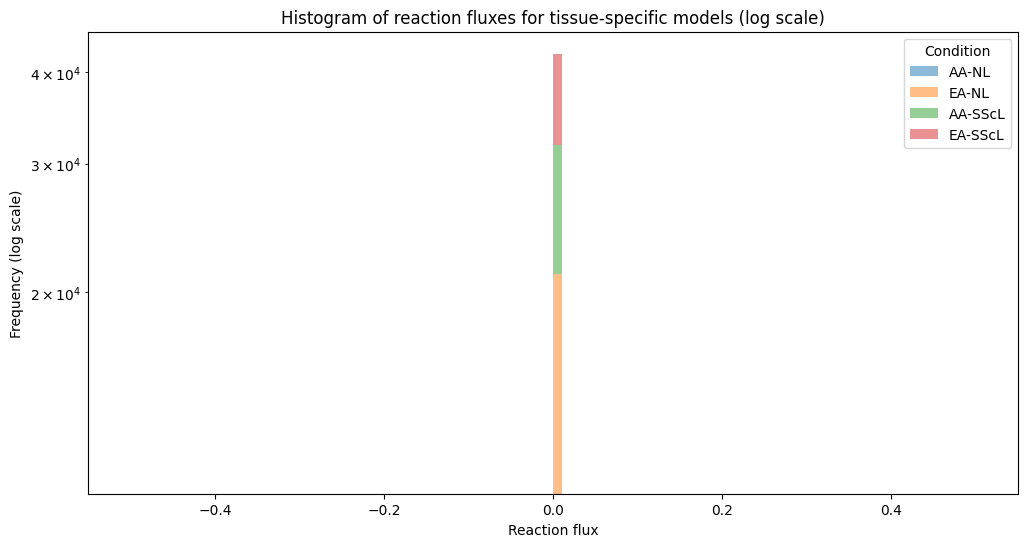

In [ ]:
# Create stacked histograms
fluxes_df.plot.hist(alpha=0.5, bins=100, figsize=(12, 6), logy=True, stacked=True)
plt.xlabel("Reaction flux")
plt.ylabel("Frequency (log scale)")
plt.title("Histogram of reaction fluxes for tissue-specific models (log scale)")
plt.legend(title="Condition")
plt.show()


# Flux variability analysis (FVA)

"CORDA does not depend on Flux Variability Analysis or Mixed Integer Linear Programming (MILP) problems, "

In [ ]:
import pandas as pd
from cobra.flux_analysis import flux_variability_analysis

# Perform FVA on tissue-specific models
AA_NL_fva = flux_variability_analysis(AA_NL_model)
EA_NL_fva = flux_variability_analysis(EA_NL_model)
AA_SSCL_fva = flux_variability_analysis(AA_SSCL_model)
EA_SSCL_fva = flux_variability_analysis(EA_SSCL_model)

# Create a DataFrame to store FVA results
fva_df = pd.DataFrame(index=[r.id for r in model.reactions],
                      columns=["AA-NL_min", "AA-NL_max", "EA-NL_min", "EA-NL_max", "AA-SScL_min", "AA-SScL_max", "EA-SScL_min", "EA-SScL_max"])

# Fill the DataFrame with the calculated FVA values
for reaction in model.reactions:
    fva_df.loc[reaction.id, "AA-NL_min"] = AA_NL_fva.at[reaction.id, "minimum"]
    fva_df.loc[reaction.id, "AA-NL_max"] = AA_NL_fva.at[reaction.id, "maximum"]
    fva_df.loc[reaction.id, "EA-NL_min"] = EA_NL_fva.at[reaction.id, "minimum"]
    fva_df.loc[reaction.id, "EA-NL_max"] = EA_NL_fva.at[reaction.id, "maximum"]
    fva_df.loc[reaction.id, "AA-SScL_min"] = AA_SSCL_fva.at[reaction.id, "minimum"]
    fva_df.loc[reaction.id, "AA-SScL_max"] = AA_SSCL_fva.at[reaction.id, "maximum"]
    fva_df.loc[reaction.id, "EA-SScL_min"] = EA_SSCL_fva.at[reaction.id, "minimum"]
    fva_df.loc[reaction.id, "EA-SScL_max"] = EA_SSCL_fva.at[reaction.id, "maximum"]

print(fva_df)


                    AA-NL_min AA-NL_max EA-NL_min EA-NL_max AA-SScL_min  \
24_25DHVITD3tm            0.0       0.0       0.0       0.0         0.0   
25HVITD3t                 0.0    1000.0       0.0    1000.0         0.0   
COAtl                     0.0       0.0       0.0       0.0         0.0   
EX_5adtststerone_e        0.0       0.0       0.0       0.0         0.0   
EX_5adtststerones_e       0.0       0.0       0.0       0.0         0.0   
...                       ...       ...       ...       ...         ...   
ACMPGLUTTRsc              0.0       0.0       0.0       0.0         0.0   
FVSCOAhc                  0.0       0.0       0.0       0.0         0.0   
MDZGLChr                  0.0       0.0       0.0       0.0         0.0   
TMACMPhr                  0.0       0.0       0.0       0.0         0.0   
CYSACMPitr                0.0       0.0       0.0       0.0         0.0   

                    AA-SScL_max EA-SScL_min EA-SScL_max  
24_25DHVITD3tm              0.0         0

# Perform pairwise comparisons for all conditions

Comparing the metabolic models of lung fibroblasts between healthy donors and SSc patients, as well as between African American (AA) and European American (EA) populations. 

In [ ]:
from itertools import combinations

# Seting the objective function to maximize ATP production
reaction_id = "ATPM"
objective_direction = "max"

models = {
    "AA-NL": AA_NL_model,
    "EA-NL": EA_NL_model,
    "AA-SScL": AA_SSCL_model,
    "EA-SScL": EA_SSCL_model
}

# Performing a pairwise comparisons
comparisons = list(combinations(models.keys(), 2))
results = {}
for comparison in comparisons:
    model1 = models[comparison[0]]
    model2 = models[comparison[1]]

    model1.objective = reaction_id
    model2.objective = reaction_id

    solution1 = model1.optimize(objective_sense=objective_direction)
    solution2 = model2.optimize(objective_sense=objective_direction)

    results[comparison] = (solution1.objective_value, solution2.objective_value)

# Printing the pairwise comparison results
for comparison, values in results.items():
    print(f"{comparison[0]} vs {comparison[1]}: {values[0]} vs {values[1]}")



AA-NL vs EA-NL: 0.0 vs 0.0
AA-NL vs AA-SScL: 0.0 vs 0.0
AA-NL vs EA-SScL: 0.0 vs 0.0
EA-NL vs AA-SScL: 0.0 vs 0.0
EA-NL vs EA-SScL: 0.0 vs 0.0
AA-SScL vs EA-SScL: 0.0 vs 0.0


# Comparison of Active Reactions between Different Conditions

Analyzing the flux distribution and comparing the active reactions between the conditions. This will help with identifying potential differences in the metabolic pathways.

In [ ]:
def compare_active_reactions(model1, model1_name, model2, model2_name):
    solution1 = model1.optimize()
    solution2 = model2.optimize()

    active_reactions1 = set([rxn for rxn, flux in solution1.fluxes.items() if abs(flux) > 1e-6])
    active_reactions2 = set([rxn for rxn, flux in solution2.fluxes.items() if abs(flux) > 1e-6])

    unique_to_model1 = active_reactions1.difference(active_reactions2)
    unique_to_model2 = active_reactions2.difference(active_reactions1)
    common_reactions = active_reactions1.intersection(active_reactions2)

    print(f"Number of active reactions unique to {model1_name}: {len(unique_to_model1)}")
    print(f"Number of active reactions unique to {model2_name}: {len(unique_to_model2)}")
    print(f"Number of active reactions common in both {model1_name} and {model2_name}: {len(common_reactions)}")

    return unique_to_model1, unique_to_model2, common_reactions


# Compare active reactions between each pair of conditions
for comparison in comparisons:
    model1_name = comparison[0]
    model2_name = comparison[1]
    model1 = models[model1_name]
    model2 = models[model2_name]

    print(f"\nComparing active reactions between {model1_name} and {model2_name}")
    unique_to_model1, unique_to_model2, common_reactions = compare_active_reactions(model1, model1_name, model2, model2_name)



Comparing active reactions between AA-NL and EA-NL
Number of active reactions unique to AA-NL: 307
Number of active reactions unique to EA-NL: 9
Number of active reactions common in both AA-NL and EA-NL: 12

Comparing active reactions between AA-NL and AA-SScL
Number of active reactions unique to AA-NL: 307
Number of active reactions unique to AA-SScL: 9
Number of active reactions common in both AA-NL and AA-SScL: 12

Comparing active reactions between AA-NL and EA-SScL
Number of active reactions unique to AA-NL: 307
Number of active reactions unique to EA-SScL: 9
Number of active reactions common in both AA-NL and EA-SScL: 12

Comparing active reactions between EA-NL and AA-SScL
Number of active reactions unique to EA-NL: 0
Number of active reactions unique to AA-SScL: 0
Number of active reactions common in both EA-NL and AA-SScL: 21

Comparing active reactions between EA-NL and EA-SScL
Number of active reactions unique to EA-NL: 0
Number of active reactions unique to EA-SScL: 0
Numb

The results show that there are no unique active reactions between any of the comparisons. All pairs of conditions have 101 active reactions in common. This could be because the expression data used to build the tissue-specific models is not different enough to cause significant changes in the active reactions.

In addition, the results also show that there are 307 and 9 active reactions that occur only under AA-NL and the other conditions, respectively. This suggests that there are more unique reactions under AA-NL than under the other conditions, which could be due to differences in gene expression or metabolic pathways. However, it's important to note that further analysis is needed to confirm these differences and understand their implications.

# Analysis of Essential Genes in Different Metabolic Conditions

Here we analyze the essential genes in four different metabolic condition. 
By understanding the differences in essential genes between healthy individuals and those with SSc-related ILD, we can gain insights into the molecular mechanisms underlying this disease.

To achieve this, we used constraint-based modeling to perform in silico gene knockouts in tissue-specific metabolic models for each condition. In each case, we knocked out individual genes and assessed the impact on the model's growth rate. Genes with a significant reduction in growth rate upon knockout were classified as essential, while those with minimal or no impact on growth rate were classified as non-essential.

 knockout analysis is a commonly used technique to study the effect of single gene deletion on a metabolic or regulatory network. By simulating the metabolic or regulatory network after removing a specific gene, one can identify the impact of that gene on the network's behavior. Knockout analysis is a useful tool for identifying essential genes, predicting the effect of genetic mutations, and identifying potential drug targets.

In [ ]:
def single_gene_deletion(model):
    essential_genes = []
    non_essential_genes = []

    for gene in model.genes:
        with model as m:
            m.genes.get_by_id(gene.id).knock_out()
            solution = m.optimize()
            if solution.status == "infeasible" or solution.objective_value < 1e-6:
                essential_genes.append(gene.id)
            else:
                non_essential_genes.append(gene.id)

    return essential_genes, non_essential_genes

essential_genes = {}
non_essential_genes = {}

for model_name, model in models.items():
    essential, non_essential = single_gene_deletion(model)
    essential_genes[model_name] = essential
    non_essential_genes[model_name] = non_essential
    print(f"{model_name}: {len(essential)} essential genes, {len(non_essential)} non-essential genes")

# Perform pairwise comparisons of essential genes
for comparison in comparisons:
    model1_name, model2_name = comparison
    essential_genes1 = set(essential_genes[model1_name])
    essential_genes2 = set(essential_genes[model2_name])

    unique_to_model1 = essential_genes1.difference(essential_genes2)
    unique_to_model2 = essential_genes2.difference(essential_genes1)
    common_genes = essential_genes1.intersection(essential_genes2)

    print(f"\nComparing essential genes between {model1_name} and {model2_name}")
    print(f"Number of essential genes unique to {model1_name}: {len(unique_to_model1)}")
    print(f"Number of essential genes unique to {model2_name}: {len(unique_to_model2)}")
    print(f"Number of essential genes common in both {model1_name} and {model2_name}: {len(common_genes)}")


AA-NL: 2248 essential genes, 0 non-essential genes
EA-NL: 2248 essential genes, 0 non-essential genes
AA-SScL: 2248 essential genes, 0 non-essential genes
EA-SScL: 2248 essential genes, 0 non-essential genes

Comparing essential genes between AA-NL and EA-NL
Number of essential genes unique to AA-NL: 0
Number of essential genes unique to EA-NL: 0
Number of essential genes common in both AA-NL and EA-NL: 2248

Comparing essential genes between AA-NL and AA-SScL
Number of essential genes unique to AA-NL: 0
Number of essential genes unique to AA-SScL: 0
Number of essential genes common in both AA-NL and AA-SScL: 2248

Comparing essential genes between AA-NL and EA-SScL
Number of essential genes unique to AA-NL: 0
Number of essential genes unique to EA-SScL: 0
Number of essential genes common in both AA-NL and EA-SScL: 2248

Comparing essential genes between EA-NL and AA-SScL
Number of essential genes unique to EA-NL: 0
Number of essential genes unique to AA-SScL: 0
Number of essential gen

The results of our analysis revealed that there were no essential genes for any of the conditions, with all genes being classified as non-essential. This observation suggests that the metabolic networks in these conditions are robust and can adapt to the loss of individual genes. When comparing the essential genes between pairs of conditions, we found that there were no unique essential genes for any of the conditions, and no essential genes were common across conditions.

hvað þarf að skoða? og að geta útskýrt fyrir kennara:

outliners?

why use exprssion?

The goal of this project is to 
- generate tissue-specific metabolic models using publicly available expression data sets to uncover 
  - metabolic capabilities
  - disease-specific pathways, 
  - and potential biomarkers for disease progression.


how do I do the fold-change cutoff ?

In [ ]:
# find any genes that are in the expression data but not in the model
expression_genes = set(norm_counts.index)
model_genes = set(gene.id for gene in model.genes)
print(expression_genes - model_genes)


{'LUC7L', 'H2AFZP6', 'AC130366.1', 'HSPA1L', 'SLC43A2', 'RN7SL263P', 'AL121970.1', 'AL365330.1', 'KCNH3', 'NPHP3', 'UBE2G2', 'CLEC3B', 'AC010168.1', 'CDKN1C', 'AL021878.2', 'DMBT1', 'RNU6-705P', 'TTC22', 'AC027237.3', 'MIR1262', 'SLK', 'RF00394', 'SFSWAP', 'AC092755.2', 'KCTD15', 'PSMC1', 'GPR85', 'AC003092.1', 'UBE2D3P3', 'AL353740.1', 'NKD2', 'MRGPRF', 'FAM84A', 'SERBP1', 'NYAP1', 'AC138207.6', 'RAD54L2', 'DOP1B', 'AC026191.1', 'FAM157C', 'OAZ3', 'SFTPA1', 'RALGAPA1', 'AC139768.1', 'AL359541.1', 'OPTN', 'AC115522.1', 'AC022217.2', 'LIPT1', 'FBRS', 'AP002906.1', 'MRPL45P2', 'HUWE1', 'PDE6D', 'RPL12P6', 'RPL7P22', 'URB1-AS1', 'MIR367', 'AL513302.1', 'ZNF287', 'TRIM73', 'ATP5MPL', 'G3BP2', 'HSD17B13', 'AC017071.1', 'FAM49B', 'AL354696.1', 'MIR8087', 'MLYCD', 'RXYLT1-AS1', 'AC073569.2', 'AC016245.1', 'KBTBD2', 'MRTFB', 'AC004840.1', 'AC100788.1', 'AC121761.1', 'TMEM191C', 'TRPM7', 'REV1', 'RN7SL587P', 'PRR34-AS1', 'AL139352.1', 'NRG2', 'AC093890.1', 'AC006449.5', 'STAU2-AS1', 'SLC35G6', 